# CAP 6618 - Machine Learning for Computer Vision

Christian Garbin
Spring 2019

# Programming Project 5
See guidelines on Canvas for details.

Source for the code is Géron's chapter 13, exercise solutions: https://github.com/ageron/handson-ml/blob/master/13_convolutional_neural_networks.ipynb. The main changes are to make the code generic, to support other datasets.

Source for models is the TF-slim library at https://github.com/tensorflow/models/tree/master/research/slim (in the future we should use TensorFlow Hub).

**IMPORTANT**: This notebook requires Python 3.x.

## Step 1: Setup

### Step 1.1: Environment setup

In [1]:
# Common imports
import numpy as np
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

### Step 1.2 Helper functions

Fetches a compressed (zipped) file from a given URL, uncompress it.

If the file has been fetched before, use the cached copy.

In [4]:
import sys
import tarfile
from six.moves import urllib

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_file(url, path):
    # Already downloaded - use the cached contents.
    # Note that it tests for the presence of the destination folder, not
    # the actual contents. Delete the entire folder to force a new download.
    if os.path.exists(path):
        print('Using cached contents from {}'.format(path))
        return
    
    # The file name from the URL - the last piece
    file_name = url.split('/')[-1]
    
    # Download to local file, extract contents
    print('Downloading {}'.format(file_name))
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, file_name)
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    tgz = tarfile.open(tgz_path)
    tgz.extractall(path=path)
    tgz.close()
    os.remove(tgz_path)

Image preprocessing and augmentation.

Sources on why we need to resize the images, even though we are using CNNs (which should have spatial independence relative to the input images):

- [To match what the original network was trained on](https://www.quora.com/Is-dimensionality-of-input-images-fixed-when-using-pre-trained-CNNs-in-Keras-for-transfer-learning), ensuring that the weights and other parameters are still applicable.
- [Mathworks doc that says we have to do it](https://www.mathworks.com/help/deeplearning/ug/preprocess-images-for-deep-learning.html), although doesn't explain the reason.
- [CNTK's tutorial](https://cntk.ai/pythondocs/CNTK_301_Image_Recognition_with_Deep_Transfer_Learning.html) also says we have to resize, without explaining why.

In [5]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255


### Step 1.3: Experiment description

This class holds data we need to run the experiment.

There is only one, global object created from this class, used in several places (not ideal, but in this context it's better than polluting the parameter list of every function or having it spread across several global variables).

In [6]:
class ExperimentData:
    '''URL for the dataset file. Expected to be a zipped file.'''
    dataset_url: str
    '''Destination folder for the dataset in the local computer.'''
    dataset_folder: str
    '''Destination folder for extracted pictures (subfolder of the above,
    usually a folder inside the zipped file).'''
    dataset_subfolder: str
    '''Class names, extracted from directory names.'''
    class_names: str
        
    '''URL for the pretrained model. Expected to be a zipped file.'''
    model_url: str
    '''Destination folder for the model.'''
    model_folder: str
    '''File name for the model.'''
    model_file_name: str
    '''The last layer we will use from the pretained model. Usually the
    layer just before the fully connected layers.'''
    model_last_layer: str

    '''Picture dimensions used in the pretrained model.'''
    width: int
    height: int
    channels: int

## Step 2: Transfer Learning for image classification using TensorFlow and pretrained model

In this step we will use a pre-trained model (*), freeze all layers up to the bottleneck layer (i.e., the last layer before the output layer), and replace the output layer with the appropriate number of outputs for a new classification task.

This section is prepared to run different experiments (individually).

Change the cell that sets `experiment = ...` to point to the experiments to run.

(*) The experiment setup accepts a URL to a model, to support other pretrained models in the future. It has been tested only with the Incpetion V3 so far.

### 5-class flower dataset

From the 5-class flowers dataset in https://www.tensorflow.org/tutorials/image_retraining.

This is the dataset from the [original notebook](https://github.com/ageron/handson-ml/blob/master/13_convolutional_neural_networks.ipynb). It is used to check the functionality of the code. Without fine tuning it should achieve over 60% accuracy.

In [7]:
flower_experiment = ExperimentData()

flower_experiment.dataset_url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
flower_experiment.dataset_folder = os.path.join('datasets', 'flowers')
flower_experiment.dataset_subfolder = os.path.join(flower_experiment.dataset_folder, 'flower_photos')

flower_experiment.model_url = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'
flower_experiment.model_folder = os.path.join('datasets', 'inception')
flower_experiment.model_file_name = os.path.join(flower_experiment.model_folder, 'inception_v3.ckpt')
flower_experiment.model_last_layer = 'PreLogits'

# Inception's image size and channels (RGB)
flower_experiment.width = 299
flower_experiment.height = 299
flower_experiment.channels = 3

### Skin cancer MNIST

From https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000:

> Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes.

Please see the appendix to create the dataset. It's not structured in classes, as the 5-class flower dataset is.

**NOTE**: Although this dataset achieved almost 70% accuracy during training, it performed poorly when verifying the actual predictions. Almost all samples in the test dataset were predicted as class 5, the class with the most number of samples by far. All in all, the experiment with this dataset can be filed under "great learning experience". A few lessons learned: 1) imbalanced datasets are hard to work with, 2) do not use a network trained on natural images to classify images from a completely different domain (or at least be prepared to unfreeze some of the CNN layers), 3) do not perform random image manipulations when there is clearly one region of interest in the image...

In [8]:
skin_cancer_mnist_experiment = ExperimentData()

skin_cancer_mnist_experiment.dataset_url = '<< see appendix >>'
skin_cancer_mnist_experiment.dataset_folder = os.path.join('datasets', 'skin-cancer-mnist-ham10000')
skin_cancer_mnist_experiment.dataset_subfolder = os.path.join(skin_cancer_mnist_experiment.dataset_folder, 'images')

skin_cancer_mnist_experiment.model_url = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'
skin_cancer_mnist_experiment.model_folder = os.path.join('datasets', 'inception')
skin_cancer_mnist_experiment.model_file_name = os.path.join(skin_cancer_mnist_experiment.model_folder, 'inception_v3.ckpt')
skin_cancer_mnist_experiment.model_last_layer = 'PreLogits'

# Inception's image size and channels (RGB)
skin_cancer_mnist_experiment.width = 299
skin_cancer_mnist_experiment.height = 299
skin_cancer_mnist_experiment.channels = 3

### Natural images

Downloaded [from Kaggle](https://www.kaggle.com/prasunroy/natural-images), originally created for the paper [Effects of Degradations on Deep Neural Network Architectures](https://arxiv.org/abs/1807.10108).

It contains eight classes, compiled from other datasets: 

- Airplane images obtained from http://host.robots.ox.ac.uk/pascal/VOC
- Car images obtained from https://ai.stanford.edu/~jkrause/cars/car_dataset.html
- Cat images obtained from https://www.kaggle.com/c/dogs-vs-cats
- Dog images obtained from https://www.kaggle.com/c/dogs-vs-cats
- Flower images obtained from http://www.image-net.org
- Fruit images obtained from https://www.kaggle.com/moltean/fruits
- Motorbike images obtained from http://host.robots.ox.ac.uk/pascal/VOC
- Person images obtained from http://www.briancbecker.com/blog/research/pubfig83-lfw-dataset

It seems like an interesting benchmark because it combines images from important datasets, such as PASCAL VOC, Stanford car dataset and ImageNet.

In [9]:
natural_images_experiment = ExperimentData()

natural_images_experiment.dataset_url = 'https://www.kaggle.com/prasunroy/natural-images/downloads/natural-images.zip/1'
natural_images_experiment.dataset_folder = os.path.join('datasets', 'natural-images')
natural_images_experiment.dataset_subfolder = os.path.join(natural_images_experiment.dataset_folder, 'natural_images')

natural_images_experiment.model_url = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'
natural_images_experiment.model_folder = os.path.join('datasets', 'inception')
natural_images_experiment.model_file_name = os.path.join(natural_images_experiment.model_folder, 'inception_v3.ckpt')
natural_images_experiment.model_last_layer = 'PreLogits'

# Inception's image size and channels (RGB)
natural_images_experiment.width = 299
natural_images_experiment.height = 299
natural_images_experiment.channels = 3

### Experiment to run

Select one of the experiments above to run.

In [10]:
experiment = natural_images_experiment

### 2.1: Fetching the data

In [11]:
fetch_file(experiment.dataset_url, experiment.dataset_folder)

Using cached contents from datasets/natural-images


Each subdirectory of the directory contains all the pictures of a given class. Let's get the list of classes:

In [12]:
experiment.class_names = sorted([dirname for dirname in os.listdir(experiment.dataset_subfolder)
                          if os.path.isdir(os.path.join(experiment.dataset_subfolder, dirname))])
experiment.class_names

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

Let's get the list of all the image file paths for each class, sort the image paths just to make this notebook behave consistently across multiple runs, and take a peek at a few samples per class.

In [13]:
from collections import defaultdict

image_paths = defaultdict(list)

for class_name in experiment.class_names:
    image_dir = os.path.join(experiment.dataset_subfolder, class_name)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[class_name].append(os.path.join(image_dir, filepath))
            
for paths in image_paths.values():
    paths.sort() 

Class: airplane


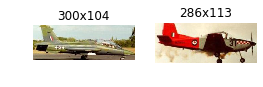

Class: car


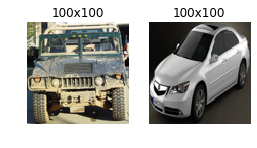

Class: cat


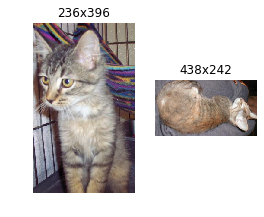

Class: dog


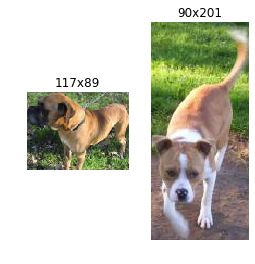

Class: flower


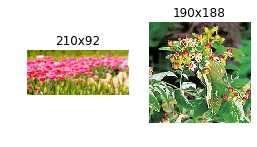

Class: fruit


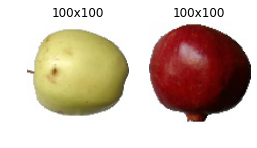

Class: motorbike


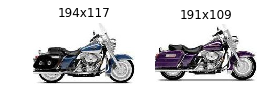

Class: person


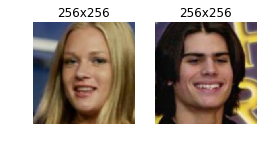

In [14]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for class_name in experiment.class_names:
    print("Class:", class_name)
    plt.figure(figsize=(4,4))
    for index, example_image_path in enumerate(image_paths[class_name][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :experiment.channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

### 2.2: Image preprocessing + data augmentation

Let's check out the result on one (random) image.

The original image.

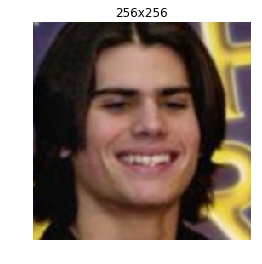

In [15]:
plt.figure(figsize=(4, 4))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

After preparing it.

/cm/shared/apps/jupyter/jupyter-tensorflow-1.13.1/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


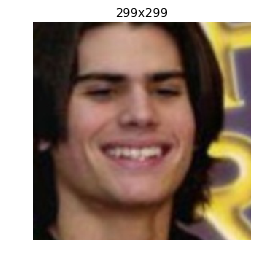

In [16]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(4, 4))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Show the random cropping and zooming of images.

/cm/shared/apps/jupyter/jupyter-tensorflow-1.13.1/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


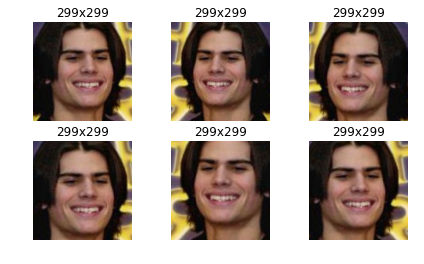

In [17]:
rows, cols = 2, 3

plt.figure(figsize=(7, 4))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

### 2.3: Load pre-trained model

Clean up data from previous runs.

In [18]:
reset_graph()

TODO: In the future: we should download from TF Hub https://www.tensorflow.org/hub/.

In [19]:
fetch_file(experiment.model_url, experiment.model_folder)

Using cached contents from datasets/inception


From Géron: Create the Inception v3 model by calling the inception_v3() function, as shown below. This must be done within an argument scope created by the inception_v3_arg_scope() function. Also, you must set `is_training=False` and `num_classes=1001` [...]

TODO: we are not setting `is_training` to False. Need to investigate how that works in this context. It looks like the `training` placeholder is hardcoded to `False`, which is effectivelly the same as setting `is_training` to `False` directly.

In [20]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

X = tf.placeholder(tf.float32,
                   shape=[None, experiment.height, experiment.width, experiment.channels],
                   name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

model_saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


List of layers in the model.

We need to find the layer that gives the predictions, so we can use the model up to that layer and plug in our prediction layer.

In this case the model is named nicely enough `PreLogits`, right before the `Predictions` layer, the one we will replace.

In [21]:
end_points

{'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=float32>,
 'Mixed_5b': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5b/concat:0' shape=(?, 35, 35, 256) dtype=float32>,
 'Mixed_5c': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5c/concat:0' shape=(?,

In [22]:
end_points[experiment.model_last_layer]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

We can drop the 2nd and 3rd dimensions using the `tf.squeeze()` function:

TODO: Understand why do we need to do this. Because we don't have a flatten layer after it?

In [23]:
reused_layer = tf.squeeze(end_points[experiment.model_last_layer], axis=[1, 2])

Then we can add the final fully connected layer on top of this layer:

(This is our new, customized prediction layer)

In [24]:
n_outputs = len(experiment.class_names)

LOGIT_LAYER_NAME = 'new_logits'

with tf.name_scope("new_output_layer"):
    new_logits = tf.layers.dense(reused_layer, n_outputs, name=LOGIT_LAYER_NAME)
    Y_proba = tf.nn.softmax(new_logits, name="Y_proba")

Instructions for updating:
Use keras.layers.dense instead.


Finally, we need to add the usual bits and pieces:

* the placeholder for the targets (`y`),
* the loss function, which is the cross-entropy, as usual for a classification task,
* an optimizer, that we use to create a training operation that will minimize the cost function,
* a couple operations to measure the model's accuracy,
* and finally an initializer and a saver.

There is one important detail, however: since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's `minimize()` method:

In [25]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=new_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=LOGIT_LAYER_NAME)
    training_op = optimizer.minimize(loss, var_list=trainable_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 
    
[v.name for v in trainable_vars]

['new_logits/kernel:0', 'new_logits/bias:0']

Notice that we created the `model_saver` before adding the new output layer: we will use this saver to restore the pretrained model state, so we don't want it to try to restore new variables (it would just fail saying it does not know the new variables). The second `saver` will be used to save the final flower model, including both the pretrained variables and the new ones.

### 2.4: Split the dataset

First, we will want to represent the classes as ints rather than strings:

In [26]:
class_ids = {class_name: index for index, class_name in enumerate(experiment.class_names)}
class_ids

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

Represent the dataset as list of filepath/class pairs.

**IMPORTANT**: Split into train and test sets as we read each folder, not after reading all files, because the classes may be imbalanced.

In [27]:
test_ratio = 0.2

paths_and_classes_train = []
paths_and_classes_test = []

for class_name, paths in image_paths.items():
    train_size = int(len(paths) * (1 - test_ratio))
    for path in paths[:train_size]:
        paths_and_classes_train.append((path, class_ids[class_name]))
    for path in paths[train_size:]:
        paths_and_classes_test.append((path, class_ids[class_name]))

np.random.shuffle(paths_and_classes_train)

Check that the train and test sets are balanced.

What we should check here: each class is represented proportionally within each set and across the sets.

In [28]:
def class_frequency(dataset, description):
    print('{} with {} samples'.format(description, len(dataset)))
    for class_name, class_index in class_ids.items():
        class_samples = [x for x in dataset if x[1] == class_index]
        print('Class: {:12s}  count: {:4d}  ratio: {:.2f}'.format(class_name,
                                                         len(class_samples),
                                                         len(class_samples)/len(dataset)))
    
class_frequency(paths_and_classes_train, 'Train dataset')
class_frequency(paths_and_classes_test, '\nTest dataset')

Train dataset with 5516 samples
Class: airplane      count:  581  ratio: 0.11
Class: car           count:  774  ratio: 0.14
Class: cat           count:  708  ratio: 0.13
Class: dog           count:  561  ratio: 0.10
Class: flower        count:  674  ratio: 0.12
Class: fruit         count:  800  ratio: 0.15
Class: motorbike     count:  630  ratio: 0.11
Class: person        count:  788  ratio: 0.14

Test dataset with 1383 samples
Class: airplane      count:  146  ratio: 0.11
Class: car           count:  194  ratio: 0.14
Class: cat           count:  177  ratio: 0.13
Class: dog           count:  141  ratio: 0.10
Class: flower        count:  169  ratio: 0.12
Class: fruit         count:  200  ratio: 0.14
Class: motorbike     count:  158  ratio: 0.11
Class: person        count:  198  ratio: 0.14


How the first few samples in the dataset looks like. Note again that they are not the actual images, but paths to them.

In [29]:
paths_and_classes_train[:3]

[('datasets/natural-images/natural_images/cat/cat_0260.jpg', 2),
 ('datasets/natural-images/natural_images/cat/cat_0519.jpg', 2),
 ('datasets/natural-images/natural_images/flower/flower_0543.jpg', 4)]

This function will be useful to preprocess the test set, and also to create batches during training.

In [30]:
from random import sample

def prepare_batch(paths_and_classes, batch_size):
    batch_paths_and_classes = sample(paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :experiment.channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch, batch_paths_and_classes


In [31]:
X_batch, y_batch, _ = prepare_batch(paths_and_classes_train, batch_size=4)

/cm/shared/apps/jupyter/jupyter-tensorflow-1.13.1/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [32]:
X_batch.shape

(4, 299, 299, 3)

In [33]:
X_batch.dtype

dtype('float32')

In [34]:
y_batch.shape

(4,)

In [35]:
y_batch.dtype

dtype('int32')

In [36]:
X_test, y_test, test_paths = prepare_batch(paths_and_classes_test, batch_size=len(paths_and_classes_test))

/cm/shared/apps/jupyter/jupyter-tensorflow-1.13.1/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [37]:
X_test.shape

(1383, 299, 299, 3)

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

### 2.5: Train the model

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.

In [38]:
import timeit
import datetime

n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(paths_and_classes_train) // batch_size

# For early stopping
best_accuracy = 0
epochs_since_last_improvement = 0
max_epochs_without_improvement = 2

print('{} iterations per epoch'.format(n_iterations_per_epoch))

with tf.Session() as sess:
    init.run()
    model_saver.restore(sess, experiment.model_file_name)

    for epoch in range(n_epochs):
        start_time = timeit.default_timer()
        print('\nEpoch {} - started {}'.format(epoch, datetime.datetime.now()))
        print('Iterations remaining: ', end='')
        for iteration in range(n_iterations_per_epoch):
            if iteration % 10 == 0:
                print('{}'.format(n_iterations_per_epoch - iteration), end=',')
            X_batch, y_batch, _ = prepare_batch(paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        elapsed = timeit.default_timer() - start_time
        print('\nTraining time: {:.2f}s  Training accuracy: {:.2f}%'.format(elapsed, acc_train*100))
        
        # Save the model from each epoch in a separate file, so we can recover the
        # one with the highest accuracy
        save_path = saver.save(sess, './my_model_epoch_{}'.format(epoch))
        
        # Early stopping
        if acc_train > best_accuracy:
            best_accuracy = acc_train
            epochs_since_last_improvement = 0
        else:
            epochs_since_last_improvement += 1
        if epochs_since_last_improvement > max_epochs_without_improvement:
            print("Early stopping!")
            break

137 iterations per epoch
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt

Epoch 0 - started 2019-04-14 15:05:38.291535
Iterations remaining: 137,

/cm/shared/apps/jupyter/jupyter-tensorflow-1.13.1/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


127,117,107,97,87,77,67,57,47,37,27,17,7,
Training time: 274.90s  Training accuracy: 100.00%

Epoch 1 - started 2019-04-14 15:10:15.203500
Iterations remaining: 137,127,117,107,97,87,77,67,57,47,37,27,17,7,
Training time: 268.90s  Training accuracy: 100.00%

Epoch 2 - started 2019-04-14 15:14:45.853447
Iterations remaining: 137,127,117,107,97,87,77,67,57,47,37,27,17,7,
Training time: 275.24s  Training accuracy: 100.00%

Epoch 3 - started 2019-04-14 15:19:22.639435
Iterations remaining: 137,127,117,107,97,87,77,67,57,47,37,27,17,7,
Training time: 275.23s  Training accuracy: 100.00%
Early stopping!


### 2.6: Evaluate the model

Select one of the trained models to evaluate (usually the one with the highest training accuracy).

In [39]:
SAVED_MODEL_PATH = './my_model_epoch_3'

In [40]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, SAVED_MODEL_PATH)

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_model_epoch_3
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.9927746


If you can afford training for 10 epochs, you should reach a ~70% accuracy. 

If you have a GPU, you can try again and let training run for much longer (e.g., using early stopping to decide when to stop). You can also improve the image preprocessing function to make more tweaks to the image (e.g., changing the brightness and hue, rotate the image slightly). You can reach above 95% accuracy on this task. 


### Predictions

In [43]:
# y = tf.placeholder(tf.int32, shape=[None])
# with tf.name_scope("eval"):
#     correct = tf.nn.in_top_k(new_logits, y, 1)
#     accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))


# with tf.Session() as sess:
#     saver.restore(sess, SAVED_MODEL_PATH)    
#     predictions = sess.run(Y_proba, feed_dict={X: X_test})

prediction_layer = new_logits

with tf.Session() as sess:
    saver.restore(sess, SAVED_MODEL_PATH)
    predictions = prediction_layer.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_epoch_3


In [44]:
print(predictions.shape)
print(predictions[0])
print(np.argmax(predictions[0]))
print(y_test[:20])
pred_class = np.argmax(predictions, axis=1)
print(pred_class)

(1383, 8)
[-5.9674187 -5.2610292 -4.5957274 -6.3976655  4.268009  -2.6531863
 -6.1762195 -4.979771 ]
4
[4 2 2 3 1 7 3 1 5 1 3 5 6 7 2 2 1 5 3 5]
[4 2 2 ... 1 2 7]


In [54]:
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'sklearn'

## Appendix

### A.1: Prepare the skin cancer MNIST folders

This section prepares the skin cancer MNIST dataset to be used with this notebook.

The notebook classification code (above) assumes that the dataset is split into folders. Each folder contains one of the classes. The skin cancer MNIST dataset is split into train, validate, test datasets instead. The code below moves the images into folders, one per class, to match what the notebook needs.

The steps to prepare the dataset:

1. Download the dataset [from Kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham100000).
1. Unzip the downloaded file.
1. Unzip the two image files, HAM10000_images_part_1.zip and HAM10000_images_part_2.zip, each into its own folder.

Once the steps above are done, we will have this folder structure:

    skin-cancer-mnist-ham10000 (main folder)
       HAM10000_images_part1 (folder for part 1 images)
       HAM10000_images_part2 (folder for part 2 images)
       ...other files from the downloaded zip

Now run the code below to prepare the dataset.

The result is stored in the `images` folder, with one subfolder for each class. This is the folder used for training and testing.

    skin-cancer-mnist-ham10000 (main folder)
       images
          bkl
          ...other categories

TODO: read folder names from `experiment`

In [ ]:
import pandas as pd
import os

# TODO: read folder names from the experiment class
MAIN_FOLDER = './datasets/skin-cancer-mnist-ham10000'

# This file has the image names (image_id) and corresponding lesion type (dx)
# image_id will be used as index column and dx as class name
image_description = pd.read_csv(os.path.join(MAIN_FOLDER, 'HAM10000_metadata.csv'),
                                index_col=1)

# Create the destination folder - subfolders for each class will be created here
image_folder = os.path.join(MAIN_FOLDER, 'images')
os.makedirs(image_folder, exist_ok=True)

# Create folders for class names and remember them
class_folders = {}
for class_name in image_description.dx.unique():
    class_folders[class_name] = os.path.join(image_folder, class_name)
    os.makedirs(class_folders[class_name], exist_ok=True)

# Move images to the corresponding folders
def move_images(source):
    source_folder = os.path.join(MAIN_FOLDER, source)
    for f in os.listdir(source_folder):
        class_name = image_description.loc[f.split('.')[0],'dx']
        os.rename(os.path.join(source_folder, f),
                  os.path.join(class_folders[class_name], f))

move_images('HAM10000_images_part_1')
move_images('HAM10000_images_part_2')

# Sanity check: metadata and folders must match
# 1) Show number of images in each directory
for class_name in class_folders:
    print('Class {} has {} images'.format(class_name,
                                          len(os.listdir(class_folders[class_name]))))
# 2) Show number of images in the metadata file
print(image_description.groupby(['dx']).size())